### Offline Data Augmentation

This notebook will handle class imbalances by augmenting imbalanced classes and normalizing them using the ResNet normalization value. First we define the data augmentation pipeline using **ImageDataGenerator**. Then, we target imbalanced classes, specifically classes with samples less than the sample mean of the entire dataset. We apply (mean - x) augmentations to those samples. The new dataset should be used only for the training set.

***1) Imports***

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

***2) Data augmentation pipeline***

Augmentations:
- Preprocessing (3x3 median filter + ResNet norm)
- Rotation (20 deg)
- Horizontal/Vertical flip (50% probability)
- Height/Width shift (0.1)
- Shear (5)
- Scaling (0.5 - 1.5)
- Brightness jittering


In [88]:
def median_filter(image):
    image = image.astype('uint8')
    filtered_image = cv2.medianBlur(image, 3)
    return filtered_image

# Define ImageNet mean and std (ensure these are defined before normalize_image)
imagenet_mean_pytorch = [0.485, 0.456, 0.406]
imagenet_std_pytorch = [0.229, 0.224, 0.225]

def normalize_image(image): # Expects input that can be cast to float32 and scaled
    # If input is uint8 from median_filter, image.astype('float32') is appropriate
    # If input is already float32 [0,255], it's also fine.
    img_float = image.astype('float32') / 255.0
    for i in range(3):
        img_float[:, :, i] = (img_float[:, :, i] - imagenet_mean_pytorch[i]) / imagenet_std_pytorch[i]
    return img_float

def preprocess(image_array):
    """
    Applies median filter and then ImageNet normalization.
    Input: image_array (typically float32 [0,255] from ImageDataGenerator)
    Output: Normalized image array (float32)
    """
    filtered_image = median_filter(image_array) # median_filter returns uint8
    normalized_image = normalize_image(filtered_image) # normalize_image handles uint8 input
    return normalized_image


In [86]:
preproc_gen = ImageDataGenerator(
    preprocessing_function=preprocess,
) # To display filtered images

aug_gen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=20,           
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=5,
    zoom_range=[0.8, 1.2],
    brightness_range=(0.8, 1.2),
    fill_mode='constant',
    cval=0
)

In [74]:
# 3) Pick a subset of 5 images
dataset_dir = "../src/data/raw/segmented"
all_paths = []
    
for root, dirs, files in os.walk(dataset_dir):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg')):
            all_paths.append(os.path.join(root, f))

all_paths = sorted(all_paths)
subset_paths = all_paths[:5]  # Pick first 5 images

In [75]:
# 4) Load them into a single NumPy batch
batch = np.stack([img_to_array(load_img(p)) for p in subset_paths], axis=0)

# 5) Display helper
def show_batch(images, title):
    plt.figure(figsize=(15,3))
    for i,img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

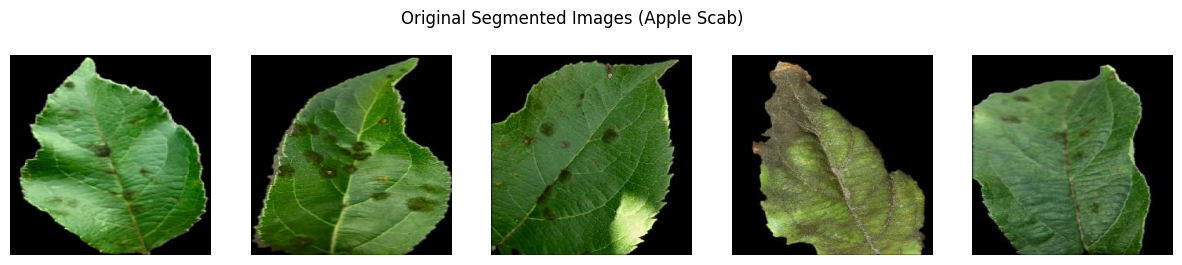

In [76]:
# 6) Original
show_batch(batch, "Original Segmented Images (Apple Scab)")

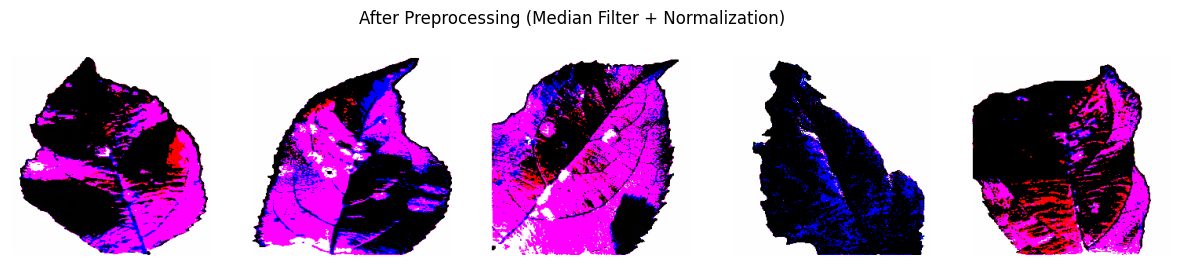

In [87]:
# 7) Preprocessed only
preproc_iter = preproc_gen.flow(batch, batch_size=5, shuffle=False)
preprocessed = next(preproc_iter)   # shape (5,H,W,3)
show_batch(preprocessed, "After Preprocessing (Median Filter + Normalization)")

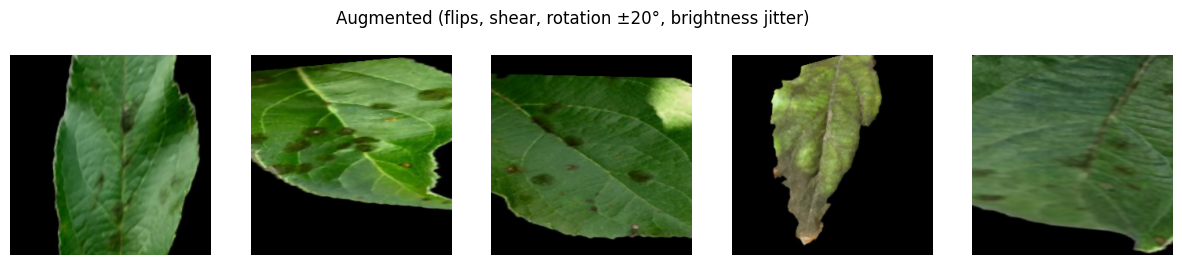

In [68]:
# 8) Augmented
aug_iter = aug_gen.flow(batch, batch_size=5, shuffle=False)
augmented = next(aug_iter)   # shape (5,H,W,3)
show_batch(augmented, "Augmented (flips, shear, rotation ±20°, brightness jitter)")

***3) Visualizing class distribution, sample sizes for each class and sample mean***

Calculating sample sizes per class...
Class: Apple___Apple_scab, Samples: 630
Class: Apple___Black_rot, Samples: 621
Class: Apple___Cedar_apple_rust, Samples: 275
Class: Apple___healthy, Samples: 1645
Class: Blueberry___healthy, Samples: 1502
Class: Cherry_(including_sour)___Powdery_mildew, Samples: 1052
Class: Cherry_(including_sour)___healthy, Samples: 854
Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, Samples: 513
Class: Corn_(maize)___Common_rust_, Samples: 1192
Class: Corn_(maize)___Northern_Leaf_Blight, Samples: 985
Class: Corn_(maize)___healthy, Samples: 1162
Class: Grape___Black_rot, Samples: 1180
Class: Grape___Esca_(Black_Measles), Samples: 1384
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Samples: 1076
Class: Grape___healthy, Samples: 423
Class: Orange___Haunglongbing_(Citrus_greening), Samples: 5507
Class: Peach___Bacterial_spot, Samples: 2297
Class: Peach___healthy, Samples: 360
Class: Pepper,_bell___Bacterial_spot, Samples: 997
Class: Pepper,_bell___heal

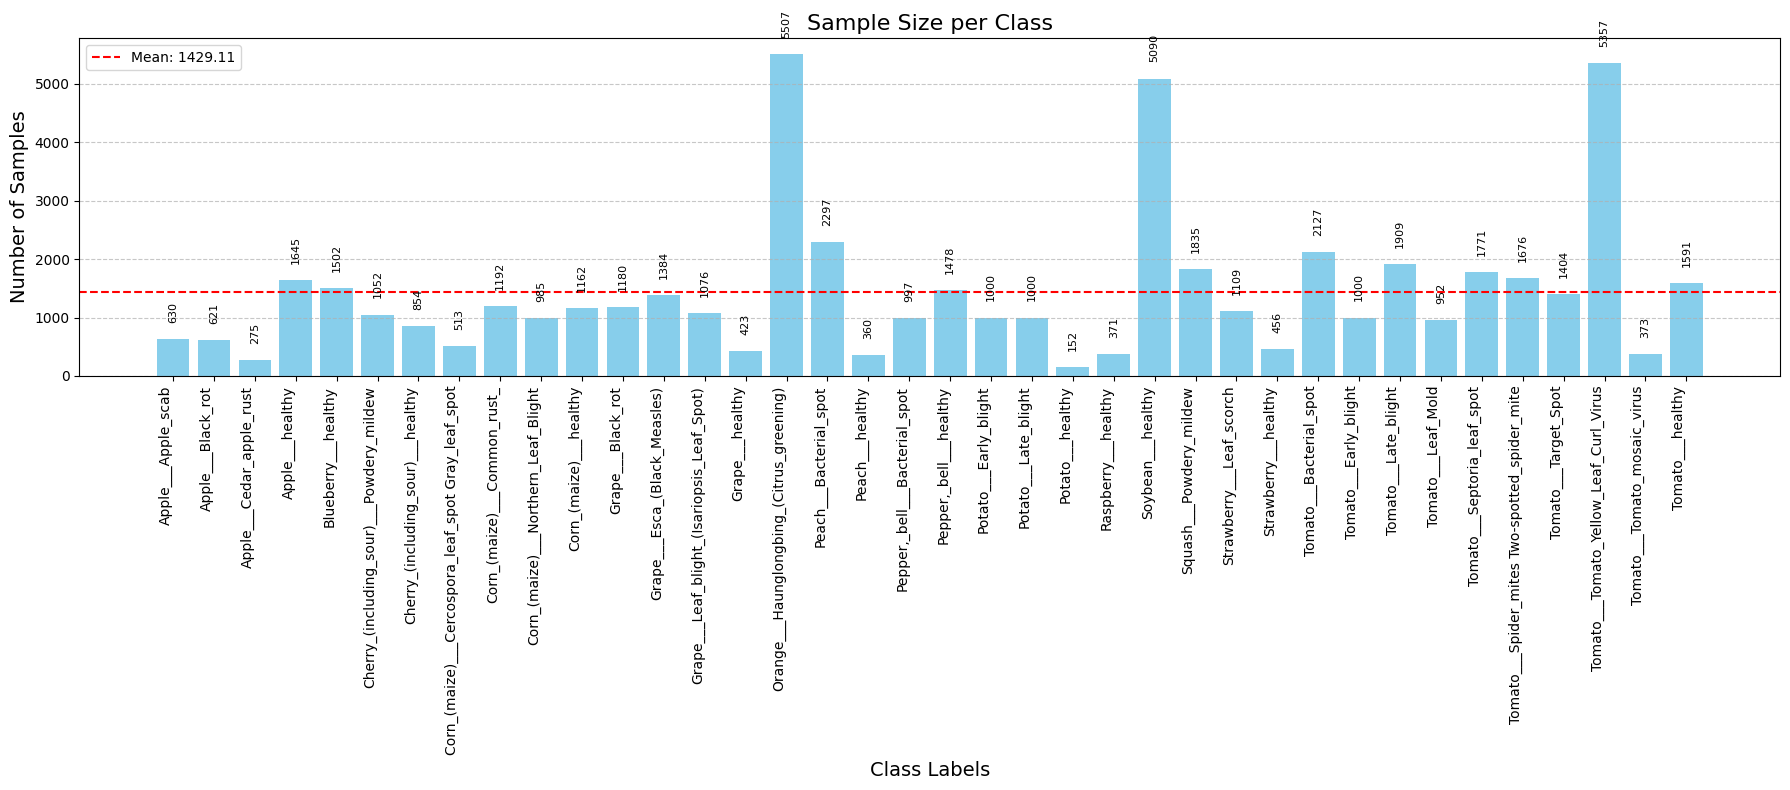

In [ ]:
if 'dataset_dir' not in globals():
    print("Error: 'dataset_dir' is not defined. Please define it in a previous cell.")
    # You might want to set a default or raise an error
    # For example: dataset_dir = "../src/data/raw/segmented" 
else:
    class_sample_counts = {}
    print("Calculating sample sizes per class...")
    if os.path.isdir(dataset_dir):
        for class_name in sorted(os.listdir(dataset_dir)): # Sort for consistent order
            class_path = os.path.join(dataset_dir, class_name)
            if os.path.isdir(class_path):
                num_samples = len([
                    f for f in os.listdir(class_path)
                    if f.lower().endswith(('.jpg'))
                ])
                class_sample_counts[class_name] = num_samples
                print(f"Class: {class_name}, Samples: {num_samples}")
    else:
        print(f"Error: Dataset directory '{dataset_dir}' not found.")

    if not class_sample_counts:
        print("No classes or samples found. Ensure the dataset_dir is correct and populated.")
    else:
        # Prepare data for the bar chart
        class_names = list(class_sample_counts.keys())
        sample_counts = list(class_sample_counts.values())
        mean_sample_size = np.mean(sample_counts) if sample_counts else 0
        print(f"Mean sample size: {mean_sample_size:.2f}")

        # Create the bar chart
        plt.figure(figsize=(18, 8)) # Adjust figure size as needed
        bars = plt.bar(class_names, sample_counts, color='skyblue')
        
        plt.xlabel("Class Labels", fontsize=14)
        plt.ylabel("Number of Samples", fontsize=14)
        plt.title("Sample Size per Class", fontsize=16)
        plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate class labels for better readability
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add the sample size number on top of each bar
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05 * max(sample_counts), # Adjust offset as needed
                     int(yval), # Display as integer
                     ha='center', va='bottom', fontsize=8, rotation=90) # Rotate text
            
        if sample_counts:
            plt.axhline(mean_sample_size, color='red', linestyle='--', label=f'Mean: {mean_sample_size:.2f}')
            plt.legend(fontsize=10)

        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()

***4) Augmenting imbalanced classes***

**4.1) Preparing file paths and labels to be augmented**

In [ ]:

# 9) Preprocessed + Augmented
def get_images(dataset_dir):
    """
    Load images from a directory and return them as a NumPy array.
    Args:
        dataset_dir (str): Path to the dataset directory.
                           Expected structure: dataset_dir/class_name/image.jpg
    """
    if not os.path.isdir(dataset_dir):
        print(f"Error: Dataset directory '{dataset_dir}' not found or is not a directory.")
        return

    class_counts = {}
    class_paths = {}
    class_image_files = {}
    
    # Assuming class names are the names of subdirectories in dataset_dir
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            images = [
                f for f in os.listdir(class_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            class_counts[class_name] = len(images)
            class_paths[class_name] = class_dir
            # Store full paths to original images for augmentation
            class_image_files[class_name] = [os.path.join(class_dir, img_f) for img_f in images]

    if not class_counts:
        print("No classes found. Ensure dataset_dir is structured as 'dataset_dir/class_name/images'.")
        return

    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)

    if num_classes == 0:
        print("No classes to process.")
        return

    mean_sample_size = int(np.ceil(total_samples / num_classes))
    print(f"\nTotal samples: {total_samples}")
    print(f"Number of classes: {num_classes}")
    print(f"Target mean sample size per class (rounded up): {mean_sample_size}")
    print("\nClasses to be augmented:")
    for class_name, count in class_counts.items():
        if count < mean_sample_size:
            print(f"{class_name}: {mean_sample_size - count} augmentations required")

    return class_counts, class_paths, class_image_files, mean_sample_size

In [52]:
class_counts, class_paths, class_image_files, mean_sample_size = get_images(dataset_dir)


Total samples: 54306
Number of classes: 38
Target mean sample size per class (rounded up): 1430

Classes to be augmented:
Apple___Apple_scab: 800 augmentations required
Apple___Black_rot: 809 augmentations required
Apple___Cedar_apple_rust: 1155 augmentations required
Cherry_(including_sour)___healthy: 576 augmentations required
Cherry_(including_sour)___Powdery_mildew: 378 augmentations required
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 917 augmentations required
Corn_(maize)___Common_rust_: 238 augmentations required
Corn_(maize)___healthy: 268 augmentations required
Corn_(maize)___Northern_Leaf_Blight: 445 augmentations required
Grape___Black_rot: 250 augmentations required
Grape___Esca_(Black_Measles): 46 augmentations required
Grape___healthy: 1007 augmentations required
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 354 augmentations required
Peach___healthy: 1070 augmentations required
Pepper,_bell___Bacterial_spot: 433 augmentations required
Potato___Early_blight: 430 a

**4.2) Normalization function to be used during augmentation**

**4.3) Apply augmentation to those classes**

Augmented images will be stored in **raw/augmented**

In [ ]:
def augment_classes(class_counts, class_image_files, mean_sample_size, aug_generator, base_dataset_dir):
    """
    Augments images in underrepresented classes to balance the dataset and saves them to a new 'augmented' directory.
    Args:
        class_counts (dict): Dictionary with class names as keys and sample counts as values.
        class_image_files (dict): Dictionary with class names as keys and lists of original image file paths.
        mean_sample_size (int): Target mean sample size for each class.
        aug_generator (ImageDataGenerator): Keras ImageDataGenerator for augmentation.
        base_dataset_dir (str): The root directory of the dataset (e.g., "../src/data/raw/segmented"). The 'augmented' folder will be created alongside 'segmented'.
    """
    
    # Determine the parent directory of the base_dataset_dir (e.g., "../src/data/raw")
    parent_dir = os.path.dirname(base_dataset_dir)
    # Define the new base directory for augmented images
    augmented_base_dir = os.path.join(parent_dir, "augmented")

    if not os.path.exists(augmented_base_dir):
        os.makedirs(augmented_base_dir)
        print(f"Created base directory for augmented images: {augmented_base_dir}")

    print("\nAugmenting data for underrepresented classes...")
    for class_name, current_count in class_counts.items():
        if current_count < mean_sample_size:
            num_to_generate = mean_sample_size - current_count
            print(f"Class '{class_name}': Has {current_count} samples. Needs to generate {num_to_generate} more to reach {mean_sample_size}.")

            original_images_in_class = class_image_files[class_name]
            if not original_images_in_class:
                print(f"  Warning: Class '{class_name}' has no original images to augment from. Skipping.")
                continue

            # Define the output directory for this specific class within the 'augmented' folder
            output_dir_for_class = os.path.join(augmented_base_dir, class_name)
            if not os.path.exists(output_dir_for_class):
                os.makedirs(output_dir_for_class)
                print(f"  Created augmented directory for class '{class_name}': {output_dir_for_class}")

            generated_count = 0
            img_idx = 0 # To cycle through original images

            while generated_count < num_to_generate:
                source_img_path = original_images_in_class[img_idx % len(original_images_in_class)]
                
                try:
                    img = load_img(source_img_path)
                    img_array = img_to_array(img)
                    img_batch = np.expand_dims(img_array, axis=0)

                    augmented_iterator = aug_generator.flow(img_batch, batch_size=1, shuffle=False)
                    augmented_img_array = next(augmented_iterator)[0]
                    
                    base, ext = os.path.splitext(os.path.basename(source_img_path))
                    new_filename = f"{base}_aug_{current_count + generated_count}{ext}"
                    # Save to the new augmented class-specific directory
                    output_path = os.path.join(output_dir_for_class, new_filename) 

                    save_img(output_path, augmented_img_array)
                    generated_count += 1
                    img_idx += 1

                    if generated_count % 50 == 0 and generated_count > 0:
                         print(f"  Generated {generated_count}/{num_to_generate} for class '{class_name}'...")

                except Exception as e:
                    print(f"  Error augmenting image {source_img_path}: {e}")
                    img_idx += 1 
                    if img_idx >= len(original_images_in_class) * (num_to_generate - generated_count + 5) : 
                        print(f"  Too many errors for class {class_name}, stopping augmentation for this class.")
                        break
            print(f"  Finished augmenting for class '{class_name}'. Generated {generated_count} new images in {output_dir_for_class}.")
        elif current_count > mean_sample_size:
            print(f"Class '{class_name}': Has {current_count} samples (more than mean of {mean_sample_size}). No augmentation performed.")
        else: 
            print(f"Class '{class_name}': Has {current_count} samples (equal to mean of {mean_sample_size}). No augmentation needed.")

    print("\nClass balancing augmentation process complete.")


In [57]:
augment_classes(class_counts, class_image_files, mean_sample_size, aug_gen, dataset_dir)

Created base directory for augmented images: ../src/data/raw\augmented

Augmenting data for underrepresented classes...
Class 'Apple___Apple_scab': Has 630 samples. Needs to generate 800 more to reach 1430.
  Created augmented directory for class 'Apple___Apple_scab': ../src/data/raw\augmented\Apple___Apple_scab
  Generated 50/800 for class 'Apple___Apple_scab'...
  Generated 100/800 for class 'Apple___Apple_scab'...
  Generated 150/800 for class 'Apple___Apple_scab'...
  Generated 200/800 for class 'Apple___Apple_scab'...
  Generated 250/800 for class 'Apple___Apple_scab'...
  Generated 300/800 for class 'Apple___Apple_scab'...
  Generated 350/800 for class 'Apple___Apple_scab'...
  Generated 400/800 for class 'Apple___Apple_scab'...
  Generated 450/800 for class 'Apple___Apple_scab'...
  Generated 500/800 for class 'Apple___Apple_scab'...
  Generated 550/800 for class 'Apple___Apple_scab'...
  Generated 600/800 for class 'Apple___Apple_scab'...
  Generated 650/800 for class 'Apple___

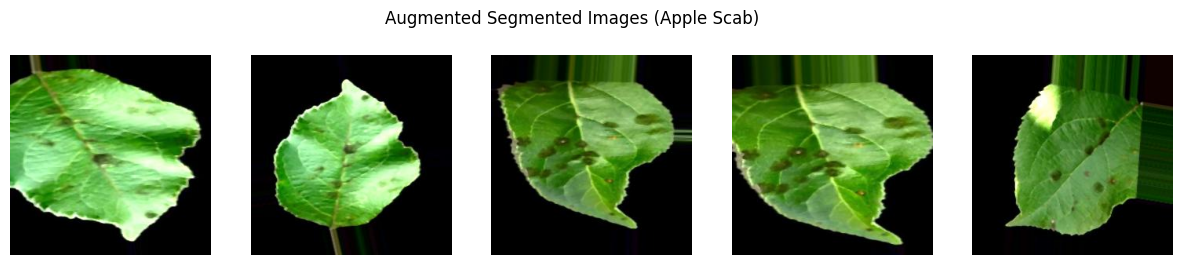

In [58]:
dataset_dir = "../src/data/raw/augmented"
all_paths = []
    
for root, dirs, files in os.walk(dataset_dir):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg')):  # Add .jpeg extension
            all_paths.append(os.path.join(root, f))

all_paths = sorted(all_paths)
subset_paths = all_paths[:5]
batch = np.stack([img_to_array(load_img(p)) for p in subset_paths], axis=0)
show_batch(batch, "Augmented Segmented Images (Apple Scab)")